# Disaster Tweet Classification with DistilBERT

## Overview

This notebook implements a natural language processing pipeline for classifying tweets as disaster-related or non-disaster-related. The project uses a fine-tuned DistilBERT model to achieve accurate text classification.

### Key Features:
- **Data Analysis**: Comprehensive exploratory data analysis with statistical insights
- **Feature Engineering**: Meta-feature extraction from tweet text
- **Text Preprocessing**: Advanced text cleaning with spell correction
- **Deep Learning**: DistilBERT fine-tuning for binary classification
- **Evaluation**: Detailed model performance analysis with visualizations

### Dataset:
The dataset contains labeled tweets with binary classification:
- `0`: Non-disaster tweets
- `1`: Disaster-related tweets

---

## 📚 Required Libraries

This section imports all necessary libraries for data processing, visualization, and machine learning.

In [5]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import warnings
warnings.filterwarnings('ignore')

# NLP libraries
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Deep learning libraries
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    get_scheduler
)
from datasets import Dataset
from tqdm import tqdm

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay

# Download required NLTK data
nltk.download('stopwords', quiet=True)

print("✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✅ All libraries imported successfully!
PyTorch version: 2.4.1+cpu
CUDA available: False


## 📊 Data Loading and Initial Analysis

In this section, we load the training and test datasets and perform initial statistical analysis to understand the data structure and characteristics.

In [6]:
# ── Data Loading & Basic Stats ──────────────────────────────────────────────────
df_train = pd.read_csv("Data/train.csv")
df_test  = pd.read_csv("Data/test.csv")

print(f"Train shape: {df_train.shape}, memory {df_train.memory_usage().sum()/1024**2:.2f} MB")
print(f"Test  shape: {df_test.shape}, memory {df_test.memory_usage().sum()/1024**2:.2f} MB")

df_train["length"] = df_train["text"].astype(str).str.len()
df_test["length"]  = df_test["text"].astype(str).str.len()

print("Train length stats:\n", df_train["length"].describe())
print("Test  length stats:\n", df_test["length"].describe())


Train shape: (7613, 5), memory 0.29 MB
Test  shape: (3263, 4), memory 0.10 MB
Train length stats:
 count    7613.000000
mean      101.161697
std        33.854073
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64
Test  length stats:
 count    3263.000000
mean      102.241189
std        34.052153
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


## 🔍 Meta-Feature Engineering

Meta-features provide additional statistical information about the text that can improve model performance. We extract various linguistic and structural features from the tweet text.

### Features Extracted:
- **Word count**: Total number of words
- **Unique word count**: Number of unique words
- **Stop word count**: Number of common English stop words
- **URL count**: Number of URLs in the text
- **Mean word length**: Average length of words
- **Character count**: Total character count
- **Punctuation count**: Number of punctuation marks
- **Hashtag count**: Number of hashtags (#)
- **Mention count**: Number of user mentions (@)

In [7]:
# extract_meta_features: compute counts (words, unique, URLs, etc.) from df['text']
def extract_meta_features(df):
    stop_words = set(stopwords.words('english'))
    mf = pd.DataFrame()
    mf['word_count']         = df['text'].str.split().str.len()
    mf['unique_word_count']  = df['text'].apply(lambda s: len(set(str(s).lower().split())))
    mf['stop_word_count']    = df['text'].apply(lambda s: sum(w in stop_words for w in str(s).lower().split()))
    mf['url_count']          = df['text'].str.count(r'http[s]?://\S+')
    mf['mean_word_length']   = df['text'].apply(lambda s: np.mean([len(w) for w in str(s).split()]) if str(s).split() else 0)
    mf['char_count']         = df['text'].str.len()
    mf['punctuation_count']  = df['text'].apply(lambda s: sum(c in string.punctuation for c in str(s)))
    mf['hashtag_count']      = df['text'].str.count('#')
    mf['mention_count']      = df['text'].str.count('@')
    return mf

print("Extracting meta features...")
train_meta = extract_meta_features(df_train)
test_meta  = extract_meta_features(df_test)

for col in train_meta:
    df_train[col] = train_meta[col]
    df_test[col]  = test_meta[col]

print("Meta features summary:\n", train_meta.describe())


Extracting meta features...
Meta features summary:
         word_count  unique_word_count  stop_word_count    url_count  \
count  7613.000000        7613.000000      7613.000000  7613.000000   
mean     14.903586          14.246158         4.582950     0.620123   
std       5.732604           5.221835         3.462259     0.663930   
min       1.000000           1.000000         0.000000     0.000000   
25%      11.000000          11.000000         2.000000     0.000000   
50%      15.000000          14.000000         4.000000     1.000000   
75%      19.000000          18.000000         7.000000     1.000000   
max      31.000000          29.000000        19.000000     4.000000   

       mean_word_length   char_count  punctuation_count  hashtag_count  \
count       7613.000000  7613.000000        7613.000000    7613.000000   
mean           6.128494   101.161697           6.839485       0.446999   
std            1.675464    33.854073           4.608758       1.099841   
min         

### 📈 Meta-Features Distribution Analysis

Let's visualize how these meta-features are distributed between disaster and non-disaster tweets. This helps us understand which features might be most discriminative for classification.

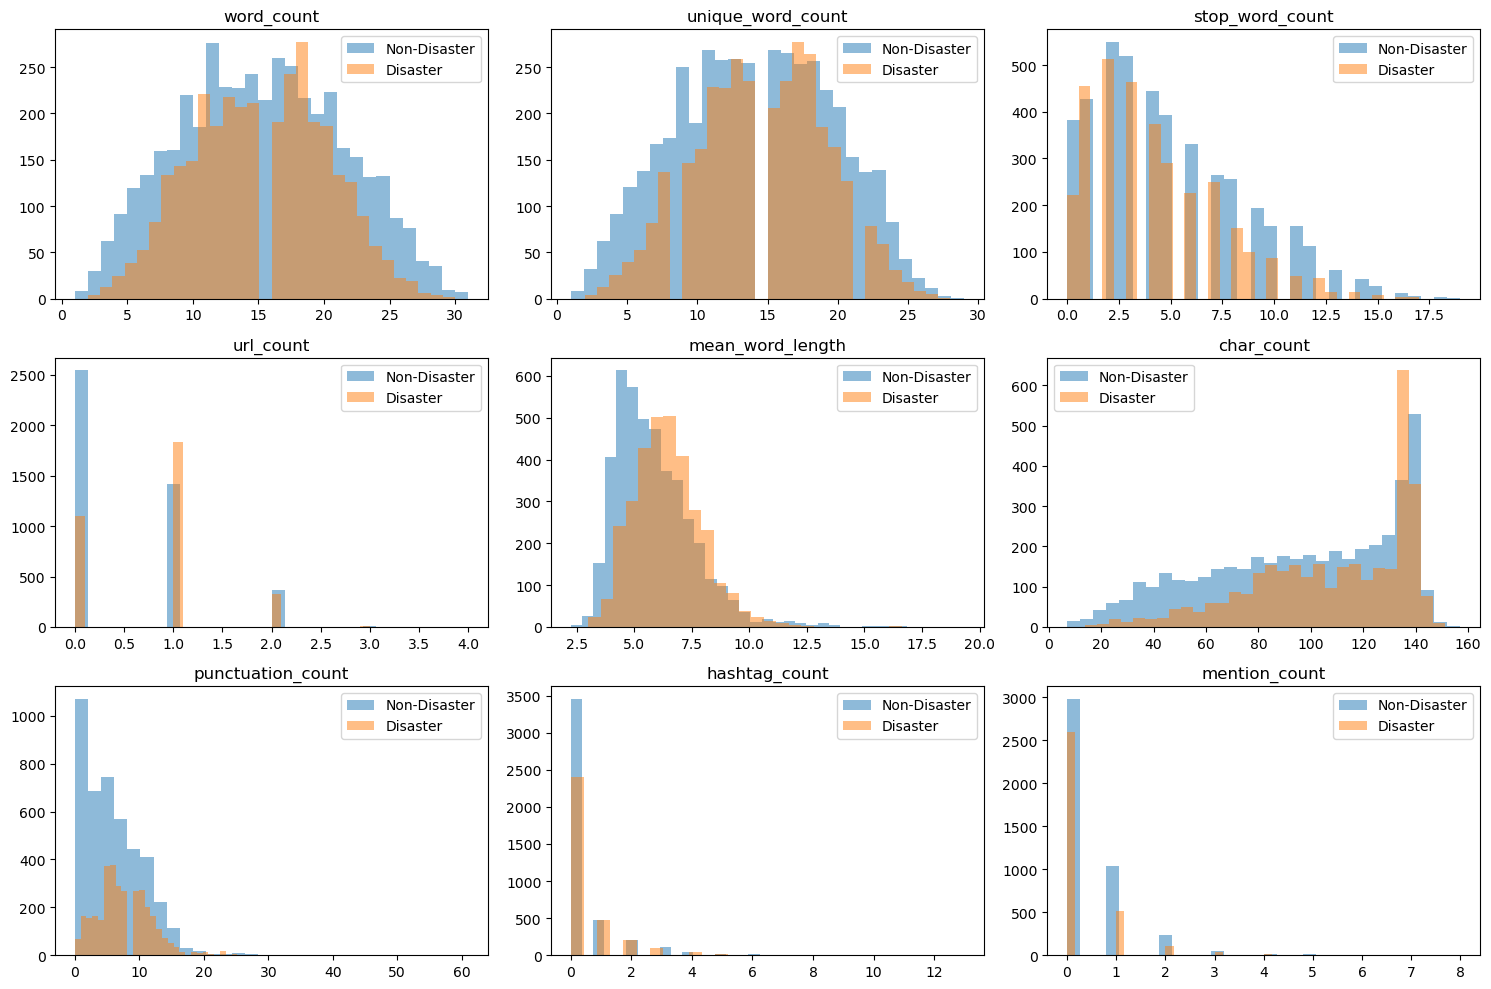

In [8]:
# Visualize each meta‐feature distribution split by target class
plt.figure(figsize=(15,10))
for i, col in enumerate(train_meta.columns, start=1):
    plt.subplot(3,3,i)
    for t, label in [(0,"Non-Disaster"), (1,"Disaster")]:
        plt.hist(df_train[df_train['target']==t][col], bins=30, alpha=0.5, label=label)
    plt.title(col); plt.legend()
plt.tight_layout(); plt.show()





## 🧹 Advanced Text Preprocessing

Text preprocessing is crucial for improving model performance. Our preprocessing pipeline includes:

### Preprocessing Steps:
1. **URL Removal**: Remove web links and URLs
2. **Email Removal**: Remove email addresses
3. **Mention Cleaning**: Remove user mentions (@username)
4. **Hashtag Processing**: Convert hashtags to regular words
5. **Number Filtering**: Remove numbers (except emergency codes like 911)
6. **Retweet Cleaning**: Remove "RT" indicators
7. **Special Character Removal**: Keep only alphanumeric and basic punctuation
8. **Repetition Reduction**: Reduce repeated characters (e.g., "sooooo" → "so")
9. **Stop Word Removal**: Remove common English stop words
10. **Spell Correction**: Use SymSpell for automatic spell correction

### Spell Correction with SymSpell
We use SymSpell, a fast and efficient spell checker, to correct common typos and misspellings in tweets.

In [10]:
from symspellpy.symspellpy import SymSpell, Verbosity

stop_words = set(stopwords.words('english'))

# Initialize SymSpell once
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
# Make sure the dictionary file is in your working directory
sym_spell.load_dictionary("frequency_dictionary_en_82_765.txt", term_index=0, count_index=1)

def clean_text(text):
    if pd.isna(text):
        return ""
    s = str(text).lower()
    s = re.sub(r'https?://\S+|www\.\S+', '', s)
    s = re.sub(r'\S+@\S+', '', s)
    s = re.sub(r'@\w+', '', s)
    s = re.sub(r'#(\w+)', r'\1', s)
    s = re.sub(r'\b\d+\b(?<!911)', '', s)
    s = re.sub(r'\brt\b', '', s)
    s = re.sub(r'[^\w\s!?]', '', s)
    s = re.sub(r'(.)\1{2,}', r'\1', s)
    tokens = s.split()
    tokens = [w for w in tokens if w not in stop_words]
    corrected = []
    for word in tokens:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        if suggestions:
            corrected.append(suggestions[0].term)
        else:
            corrected.append(word)
    return ' '.join(corrected)



2025-05-26 01:27:57,962: E symspellpy.symspellpy] Dictionary file not found at frequency_dictionary_en_82_765.txt.


### 🌟 Word Cloud Visualization

Word clouds help us visualize the most frequent words in disaster vs. non-disaster tweets after preprocessing. This provides insights into the vocabulary differences between the two classes.

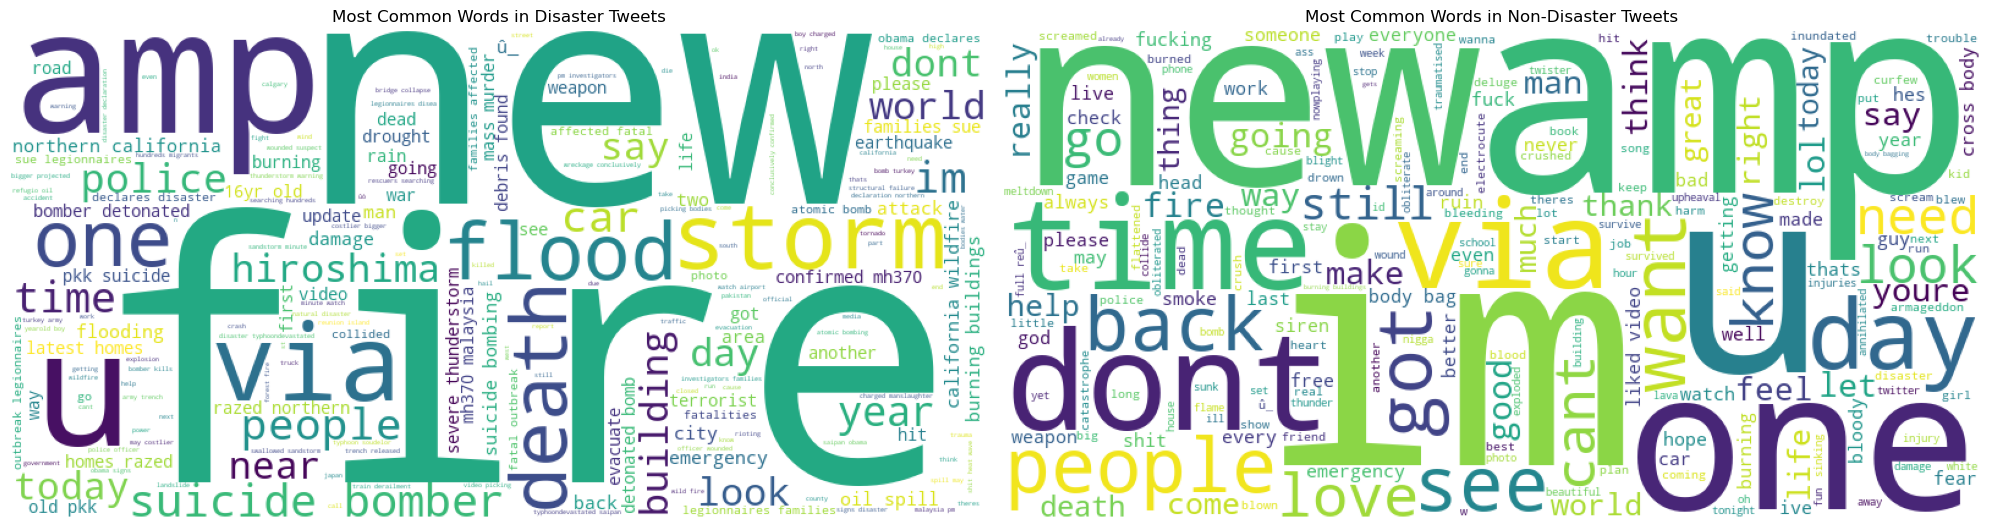

In [11]:
# Get cleaned words for disaster and non-disaster tweets
dis_words = df_train[df_train['target'] == 1]['text'].apply(clean_text).str.cat(sep=' ').split()
non_dis_words = df_train[df_train['target'] == 0]['text'].apply(clean_text).str.cat(sep=' ').split()

# Generate word clouds for disaster vs. non-disaster tweets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

wc_disaster = WordCloud(width=800, height=400, background_color='white')\
    .generate(' '.join(dis_words))
wc_non_disaster = WordCloud(width=800, height=400, background_color='white')\
    .generate(' '.join(non_dis_words))

ax1.imshow(wc_disaster)
ax1.axis('off')
ax1.set_title('Most Common Words in Disaster Tweets')

ax2.imshow(wc_non_disaster)
ax2.axis('off')
ax2.set_title('Most Common Words in Non-Disaster Tweets')

plt.tight_layout()
plt.show()

## 🤖 Model Preparation and Tokenization

This section prepares the data for the DistilBERT model by:

### Configuration:
- **Model**: DistilBERT (distilbert-base-uncased)
- **Max Length**: 160 tokens (optimal for tweets)
- **Batch Size**: 32
- **Validation Split**: 20%

### Data Pipeline:
1. **Tokenization**: Convert text to DistilBERT tokens
2. **Train-Validation Split**: Stratified split to maintain class balance
3. **Dataset Creation**: Convert to PyTorch tensors
4. **DataLoader Setup**: Batch processing with custom collate function

### Helper Functions:
- `tokenize_batch()`: Tokenizes text batches
- `collate_fn()`: Batches data for training
- `get_predictions()`: Extracts model predictions
- `display_confusion_matrix()`: Visualizes classification results

In [13]:
# ── Tokenization & DataLoader Prep ────────────────────────────────────────────
BATCH_SIZE = 32
VAL_SPLIT  = 0.2
MAX_LENGTH = 160
MODEL_NAME = "distilbert-base-uncased"

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
def tokenize_batch(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=MAX_LENGTH)

from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df_train, test_size=VAL_SPLIT, random_state=42, stratify=df_train["target"])

train_ds = Dataset.from_pandas(train_df).map(tokenize_batch, batched=True)
val_ds   = Dataset.from_pandas(val_df).map(tokenize_batch, batched=True)
test_ds  = Dataset.from_pandas(df_test).map(tokenize_batch, batched=True)

drop_cols = ["__index_level_0__", "length"]
train_ds = train_ds.remove_columns([c for c in drop_cols if c in train_ds.column_names])
val_ds   = val_ds.remove_columns(  [c for c in drop_cols if c in val_ds.column_names])
test_ds  = test_ds.remove_columns( [c for c in drop_cols if c in test_ds.column_names])

train_ds = train_ds.rename_column("target", "labels")
val_ds   = val_ds.rename_column("target", "labels")

train_ds.set_format('torch', columns=['input_ids','attention_mask','labels'])
val_ds.set_format('torch',   columns=['input_ids','attention_mask','labels'])
test_ds.set_format('torch',  columns=['input_ids','attention_mask'])

# collate_fn: batch inputs into tensors
def collate_fn(batch):
    input_ids = torch.stack([x['input_ids'] for x in batch])
    attention_mask = torch.stack([x['attention_mask'] for x in batch])
    labels = torch.tensor([x['labels'] for x in batch]) if 'labels' in batch[0] else None
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


# get_predictions: return (true_labels, predicted_probs) for any DataLoader
def get_predictions(loader):
    model.eval()
    all_labels, all_probs = [], []
    with torch.no_grad():
        for batch in loader:
            inputs = {k: v.to(device) for k,v in batch.items() if k!='labels'}
            logits = model(**inputs).logits
            probs = torch.softmax(logits, dim=-1)
            all_probs.append(probs.cpu().numpy())
            if 'labels' in batch:
                all_labels.append(batch['labels'].cpu().numpy())
    return np.concatenate(all_labels, axis=0), np.concatenate(all_probs, axis=0)


# display_confusion_matrix: plot CM and print weighted F1
def display_confusion_matrix(y_true, y_probs, name):
    preds = np.argmax(y_probs, axis=1)
    cm = confusion_matrix(y_true, preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Non-Disaster", "Disaster"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix — {name}")
    plt.show()
    print(f"{name} F1 score: {f1_score(y_true, preds, average='weighted'):.2f}")


Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

## 🚀 Model Initialization

We initialize the DistilBERT model for sequence classification with:

### Model Configuration:
- **Architecture**: DistilBERT for Sequence Classification
- **Number of Labels**: 2 (binary classification)
- **Optimizer**: AdamW with learning rate 1e-5
- **Scheduler**: Linear learning rate scheduling
- **Device**: CUDA if available, otherwise CPU

### Training Setup:
- **Epochs**: 2
- **Gradient Clipping**: Max norm of 1.0 for stability
- **Model Saving**: Best model based on validation F1 score

In [14]:
# ── Model Initialization ──────────────────────────────────────────────────────
model  = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer     = AdamW(model.parameters(), lr=1e-5)
num_steps     = 2 * len(train_loader)
lr_scheduler  = get_scheduler("linear", optimizer, num_warmup_steps=0, num_training_steps=num_steps)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 🏋️ Model Training

The training loop implements:

### Training Process:
1. **Forward Pass**: Compute predictions and loss
2. **Backward Pass**: Calculate gradients
3. **Gradient Clipping**: Prevent exploding gradients
4. **Parameter Update**: Apply AdamW optimizer
5. **Validation**: Evaluate on validation set after each epoch
6. **Model Saving**: Save best model based on F1 score

### Monitoring:
- Training loss per epoch
- Validation confusion matrix
- Validation F1 score
- Best model checkpointing

Epoch 1: 100%|██████████| 191/191 [13:21<00:00,  4.19s/it]


Epoch 1 — avg loss: 0.4877


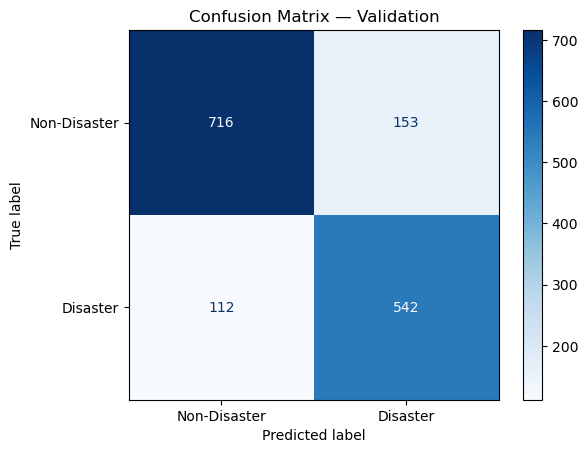

Validation F1 score: 0.83
Saved best model (F1=0.8265)


Epoch 2:  47%|████▋     | 90/191 [06:02<06:46,  4.03s/it]


KeyboardInterrupt: 

In [15]:
# ── Training Loop ─────────────────────────────────────────────────────────────
best_f1 = 0.0
for epoch in range(1, 3):
    model.train()
    total_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
        batch = {k: v.to(device) for k,v in batch.items()}
        optimizer.zero_grad()
        loss = model(input_ids=batch['input_ids'],
                     attention_mask=batch['attention_mask'],
                     labels=batch['labels']).loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()
        total_loss += loss.item()
    print(f"Epoch {epoch} — avg loss: {total_loss/len(train_loader):.4f}")

    # Validation
    y_val, p_val = get_predictions(val_loader)
    display_confusion_matrix(y_val, p_val, "Validation")
    f1_val = f1_score(y_val, np.argmax(p_val, axis=1), average='weighted')
    if f1_val > best_f1:
        best_f1 = f1_val
        torch.save(model.state_dict(), "best_model.pt")
        print(f"Saved best model (F1={best_f1:.4f})")


## 📊 Model Evaluation

### Training Set Performance
Let's evaluate how well our model performs on the training data to check for overfitting and overall learning.

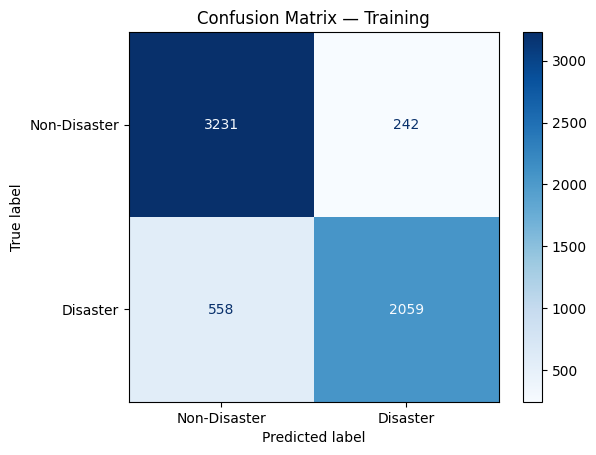

Training F1 score: 0.87


In [ ]:
# ── Final Evaluation ──────────────────────────────────────────────────────────
y_train, p_train = get_predictions(train_loader)
display_confusion_matrix(y_train, p_train, "Training")


## 📈 Enhanced Training with Metrics Tracking

This section implements an enhanced training loop that tracks comprehensive metrics:

### Metrics Tracked:
- **Loss**: Training and validation loss
- **Accuracy**: Training and validation accuracy
- **F1 Score**: Training and validation F1 score (weighted)

### Visualization:
The `plot_train_val_metrics()` function will show:
- Loss curves over epochs
- Accuracy progression
- F1 score trends
- Training vs. validation comparison

Yeal:
This is where I am writing down observations and thoughts
In preprocessing, start compiling list of things to check/address in data cleanup and see how it impacts noise 


In case of nonlinear model
--Run POS to identify parts of speech, filter the data, drop unrelated words

In [ ]:
num_epochs = 2

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1s = []
val_f1s = []

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        outputs = model(input_ids=batch['input_ids'],
                        attention_mask=batch['attention_mask'],
                        labels=batch['labels'])
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        total_loss += loss.item()
        preds = outputs.logits.argmax(dim=1)
        correct += (preds == batch['labels']).sum().item()
        total += batch['labels'].size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(correct / total)
    train_f1s.append(f1_score(all_labels, all_preds, average='weighted'))

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(input_ids=batch['input_ids'],
                            attention_mask=batch['attention_mask'],
                            labels=batch['labels'])
            val_loss += outputs.loss.item()
            preds = outputs.logits.argmax(dim=1)
            val_correct += (preds == batch['labels']).sum().item()
            val_total += batch['labels'].size(0)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(batch['labels'].cpu().numpy())
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)
    val_f1s.append(f1_score(val_labels, val_preds, average='weighted'))

print("\n✅ Enhanced training completed!")
print(f"Final Training Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

KeyboardInterrupt: 

In [ ]:
def plot_train_val_metrics(train_losses, val_losses, train_accuracies, val_accuracies, train_f1s, val_f1s):
    """
    Plot training and validation metrics over epochs.
    
    Args:
        train_losses, val_losses: Loss values for each epoch
        train_accuracies, val_accuracies: Accuracy values for each epoch
        train_f1s, val_f1s: F1 score values for each epoch
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    epochs = range(1, len(train_losses) + 1)
    
    # Plot Loss
    axes[0].plot(epochs, train_losses, 'b-', label='Training Loss', marker='o')
    axes[0].plot(epochs, val_losses, 'r-', label='Validation Loss', marker='s')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot Accuracy
    axes[1].plot(epochs, train_accuracies, 'b-', label='Training Accuracy', marker='o')
    axes[1].plot(epochs, val_accuracies, 'r-', label='Validation Accuracy', marker='s')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot F1 Score
    axes[2].plot(epochs, train_f1s, 'b-', label='Training F1', marker='o')
    axes[2].plot(epochs, val_f1s, 'r-', label='Validation F1', marker='s')
    axes[2].set_title('Training and Validation F1 Score')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('F1 Score')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    print(f"\n📊 Final Training Metrics:")
    print(f"Training - Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]:.4f}, F1: {train_f1s[-1]:.4f}")
    print(f"Validation - Loss: {val_losses[-1]:.4f}, Accuracy: {val_accuracies[-1]:.4f}, F1: {val_f1s[-1]:.4f}")
    
    # Check for overfitting
    if train_accuracies[-1] - val_accuracies[-1] > 0.1:
        print("\n⚠️  Potential overfitting detected (training accuracy >> validation accuracy)")
    else:
        print("\n✅ Model shows good generalization")

In [ ]:
# Now call the plotting function
plot_train_val_metrics(train_losses, val_losses, train_accuracies, val_accuracies, train_f1s, val_f1s)